<a href="https://colab.research.google.com/github/Michael-Jimenez-C/CieCom2/blob/main/proyecto_CII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sympy as sp

In [2]:
class Cuarto:
  def __init__(self,capacitancia,temperatura,fuente=0,Rfuente=1):
    t=sp.symbols("t")
    self.temperatura=temperatura
    self.adyacentes=[]#[(nodo,resistencia)]
    self.capacitancia=capacitancia
    self.fuente=fuente
    self.Rfuente=Rfuente
  def eq(self):
    equ=0
    if type(self.fuente)!=list:
      equ+=(self.fuente-self.temperatura if self.fuente!=0 else 0)/self.Rfuente
    else:
      for i,j in zip(self.fuente,self.Rfuente):
        equ+=(i-self.temperatura if i!=0 else 0)/j
    for i in self.adyacentes:
      equ+=(i[0].temperatura-self.temperatura)*sp.Rational(1,i[1])
    return sp.simplify(equ*sp.Rational(1,self.capacitancia))

aire
$$C_a=(\rho*V)*c=\approx 1.214J/m^3*V$$
$\rho=\frac{P_s}{287.058j/(kg*K)\cdot T_a}=\text{densidad del aire}\approx1.2kg/m^3$

$c\approx0.24$

No varía significativamente entre 0 y 40 grados, y la variación entre aire humedo y seco no es muy significativa

Agua

$$C_a\approx4184J/m^3$$
$c=1$

Suponiendo pisos de 2.5m de alto:
$C_a=3.035J/m^2*A$

In [3]:
resistencias_termicas = {
    'Ladrillo': 0.069, # en m²K/W,
    'Madera': 0.769,
    'Bloque de concreto': 0.110,
    'Hormigón': 0.800,
    'Fibra de vidrio': 3.040,
    'Lana mineral': 2.800,
    'Poliestireno expandido': 0.038,
    'Poliestireno extruido': 0.035,
    'Aislamiento de celulosa': 0.050,
    'Aislamiento de corcho': 0.043,
    'Aislamiento de lana de oveja': 0.045,
    'Aislamiento de fibra de cáñamo': 0.044,
    'Drywall': 0.131
}


In [15]:
t,s=sp.symbols("t s")
T1,T2,T3=sp.symbols("T_{1} T_{2} T_{3}")
A1=Cuarto(3.035*2,T1,sp.symbols("T_{i1}"))
B1=Cuarto(3.035*25,T2,0)
C1=Cuarto(3.035*120,T3,sp.symbols("T_{i2}"),Rfuente=resistencias_termicas["Poliestireno expandido"])

A1.adyacentes=[(B1,resistencias_termicas["Drywall"])]
B1.adyacentes=[(A1,resistencias_termicas["Drywall"]),(C1,resistencias_termicas["Ladrillo"])]
C1.adyacentes=[(A1,resistencias_termicas["Ladrillo"])]

nodos=[A1,B1,C1]

In [16]:
variables=sp.symbols("T_{1} T_{2} T_{3}")
entradas=sp.symbols("T_{i1} T_{i2}")
A=[]
B=[]
for i in range(len(nodos)):
  A.append([])
  B.append([])
  eq=nodos[i].eq()
  for j in range(len(variables)):
    A[-1].append(eq.coeff(variables[j]))
  for j in range(len(entradas)):
    B[-1].append(eq.coeff(entradas[j]))

A=sp.N(sp.Matrix(A),2)
B=sp.N(sp.Matrix(B),2)
A,B

(Matrix([
 [-1.4,   1.3,     0],
 [ 0.1, -0.29,  0.19],
 [0.04,     0, -0.11]]),
 Matrix([
 [0.16,     0],
 [   0,     0],
 [   0, 0.072]]))

In [ ]:
class Edificio:
  pass

r

In [6]:
def eAt(A,t):
  T,D=sp.N(A,2).diagonalize()
  return T*sp.exp(D*t)*T.inv()

In [8]:
def solucionTiempo(A,B,x0,u):
  t=sp.symbols("t")
  EAT=eAt(A,t)
  tau=sp.symbols("\tau") 
  return EAT*x0+sp.integrate(EAT.subs(t,tau)*B*u.subs(t,t-tau),(tau,0,t))

In [ ]:
def solucionFrecuencia(A,B,x0,u):
  t,s=sp.symbols("t s")
  U=sp.laplace_transform(u,t,s,noconds=True)
  Y=(s*sp.eye(A.shape[0])-A).inv()@(x0+B*U)
  sol=sp.inverse_laplace_transform(sp.expand(Y),s,t)
  return sol


In [17]:
x0=sp.Matrix([[15],[15],[15]])
u=sp.Matrix([[30],[15]])

In [ ]:
sol=solucionFrecuencia(A,B,x0,u)
sol
sp.N(sol[0].subs(t,10))

In [18]:
sol=solucionTiempo(A,B,x0,u)
sol
sp.N(sol[0].subs(t,10))

17.5782746873425

In [19]:
sp.N(sol[0].subs(t,1000))

18.5709369229521

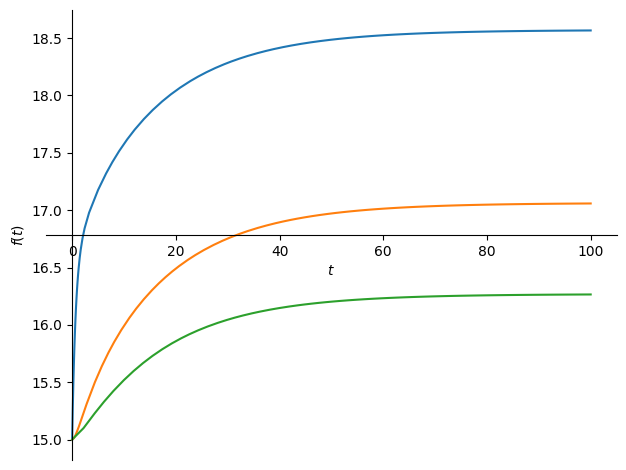

In [20]:
sp.plot(sol[0],sol[1],sol[2],(t,0,100))